# Debiasing Molecule Dataset

## Load Molecule Dataset and Compute ECFP Fingerprints

In [16]:
# imports

import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import DataStructs
from rdkit.Chem import AllChem
# import cairosvg
from rdkit.Chem.Draw import IPythonConsole
from rdkit.DataManip.Metric.rdMetricMatrixCalc import GetTanimotoDistMat
from IPython.display import SVG
from IPython.display import Markdown
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from umap import UMAP

from selector.methods.distance import MaxMin, MaxSum, OptiSim, DISE
from selector.methods.partition import Medoid, GridPartition
from selector.diversity import compute_diversity
from selector.methods.similarity import NSimilarity

In [17]:
def render_table(data, caption=None, decimals=3):
    """Renders a list of lists in ta markdown table for easy visualization.

    Parameters
    ----------
    data : list of lists
        The data to be rendered in a table, each inner list represents a row with the first row
        being the header.
    caption : str, optional
        The caption of the table.
    decimals : int, optional
        The number of decimal places to round the data to.
    """

    # check all rows have the same number of columns
    if not all(len(row) == len(data[0]) for row in data):
        raise ValueError("Expect all rows to have the same number of columns.")

    if caption is not None:
        # check if caption is a string
        if not isinstance(caption, str):
            raise ValueError("Expect caption to be a string.")
        tmp_output = f"**{caption}**\n\n"

    # get the width of each column (transpose the data list and get the max length of each new row)
    colwidths = [ max(len(str(s)) for s in col) + 2 for col in zip(*data) ]

    # construct the header row
    header = f"| {' | '.join(f'{str(s):^{w}}' for s, w in zip(data[0], colwidths))} |"
    tmp_output += header+"\n"

    # construct a separator row
    separator = f"|{'|'.join(['-' * w for w in colwidths])}|"
    tmp_output+=separator+"\n"

    # construct the data rows
    for row in data[1:]:
        # round the data to the specified number of decimal places
        row = [round(s, decimals) if isinstance(s, float) else s for s in row]
        row_str = f"| {' | '.join(f'{str(s):^{w}}' for s, w in zip(row, colwidths))} |"
        tmp_output+=row_str+"\n"

    return display(Markdown(tmp_output))

In [18]:
def mol_loader(
    file_name: str,
    remove_hydrogen: bool = False,
    # force_field: str = None,
) -> list:
    """Load molecules as RDKit object.

    Parameters
    ----------
    file_name : str
        Input molecular file.
    remove_hydrogen : bool, optional
        To remove the hydrogen atoms. Default=False.

    Returns
    -------
    mols: list
        A list of RDKit molecule object.
    """

    # SDF
    # use `str` function to support PosixPath
    if str(file_name).lower().endswith(".sdf"):
        suppl = Chem.SDMolSupplier(file_name, removeHs=remove_hydrogen, sanitize=True)
        mols = [mol for mol in suppl]
    else:
        raise ValueError(f"{file_name} is not supported.")

    return mols

In [19]:
def compute_mol_ecfp(mols: list, radius: int = 3, n_bits: int = 1024) -> np.ndarray:
    """Compute ECFP fingerprints.

    Parameters
    ----------
    mols : list
        A list of RDKit molecule object.
    radius : int, optional
        The maximum radius of the substructure that is generated at each atom. Default=3.
    n_bits : int, optional
        Number of bits of fingerprint. Default=1024.

    Returns
    -------
    fps : list
        A list of RDKit fingerprint object.
    fingerprints_np : np.ndarray
        A numpy array of fingerprints.

    """
    fps = [
       AllChem.GetMorganFingerprintAsBitVect(
            mol=mol,
            radius=radius,
            nBits=n_bits,
        )
        for mol in mols
    ]

    # convert the fingerprints to numpy arrays
    fingerprints_np = []
    for fp in fps:
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp, arr)
        fingerprints_np.append(arr)

    fingerprints_np = np.array(fingerprints_np)

    return fps, fingerprints_np


In [20]:
# load molecules
mols = mol_loader(file_name="data/demo_mols_2d.sdf", remove_hydrogen=False)
# shuffle the molecules
np.random.shuffle(mols)
# compute ECFP fingerprints
fps, arr_fp = compute_mol_ecfp(mols=mols, radius=3, n_bits=1024)


In [21]:
arr_fp.shape


(97, 1024)

## Visualize Molecules

In [22]:
# set the drawing options
IPythonConsole.drawOptions.legendFontSize = 18
IPythonConsole.drawOptions.minFontSize = 16

In [23]:
# define the function to visualize the chemical structures

def visualize_mols(
        input_sdf="demo_mols_2d.sdf",
        selected_ids=None,
        show_mol_labels=False,
        sub_image_size=(150, 150),
        mols_per_row=6,
):
    """Visualize molecule dataset.

    Parameters
    ----------
    input_sdf : str, optional
        Input SDF file. Default="demo_mols_2d.sdf".
    selected_ids : list, optional
        A list of selected molecule IDs. Default=None.
    show_mol_labels : bool, optional
        To show molecule labels. Default=False.
    sub_image_size : tuple, optional
        Sub-image size. Default=(150, 150).
    mols_per_row : int, optional
        Number of molecules per row. Default=6.

    Returns
    -------
    img : IPython.display.SVG
        A SVG object.

    """

    suppl = Chem.SDMolSupplier(input_sdf, removeHs=True)
    mols = [mol for mol in suppl]

    # selected mols
    if selected_ids is None:
        mols = np.array(mols)
    else:
        mols = np.array(mols)[selected_ids]

    if show_mol_labels:
        label_list = [mol.GetProp("_Name").split(".")[0] for mol in mols]

        # img = Draw.MolsToGridImage(
        #     mols,
        #     legends=label_list,
        #     molsPerRow=6,
        #     subImgSize=sub_image_size,
        #     maxMols=999999,
        # )
        # png = img.data
        # # https://gist.github.com/greglandrum/56a80e84676fc3a24250b821d0faac13
        # with open("chem_structures.png", "wb+") as f:
        #     f.write(png)

        # or
        # img
        # right click to save
        img = Draw.MolsToGridImage(
            mols,
            legends=label_list,
            molsPerRow=mols_per_row,
            subImgSize=sub_image_size,
            useSVG=True,
            maxMols=999999,
        )
    else:
        img = Draw.MolsToGridImage(
            mols,
            molsPerRow=mols_per_row,
            subImgSize=sub_image_size,
            useSVG=True,
            maxMols=999999,
        )
    return img


In [24]:
# visualize all molecules in the dataset with TSNE projection
def graph_data_2d(
    X_dist,
    projection_method="umap",
    indices=None,
    labels=None,
    reference=False,
    figsize=(8, 8),
    title="",
    xlabel="",
    ylabel="",
    number=False,
    fname=None,
):
    """Graphs the data in a scatter plot.

    Parameters
    ----------
    data : numpy.ndarray of shape (n_samples, 2)
        The original data points to be graphed.
    projection_method : str, optional
        The dimensionality reduction method used to project the data points, which can be "umap"
        or "tsne". Default="umap".
    indices : list of numpy.ndarray, optional
        List of indices array of the data points selected.
    labels : list of str, optional
        List of labels denoting method for selected indices.
    reference : bool, optional
        Whether to highlight the first data point.
    figsize : tuple, optional
        The figure size.
    title : str, optional
        The title of the plot.
    xlabel : str, optional
        The label of the x-axis.
    ylabel : str, optional
        The label of the y-axis.
    number : bool, optional
        Whether to label the selected data points with numbers representing the order of selection.
    fname : str, optional
        Filename for saving the figure. If None, figure is shown.

    """
    if indices is not None and labels is not None and len(indices) != len(labels):
        raise ValueError(
            f"Expect indices and labels to have the same length, got {len(indices)} and {len(labels)}."
        )

    if projection_method == "tsne":
        # tsne projections into 2D
        tsne = TSNE(n_components=2,
                random_state=42,
                perplexity=2,
                early_exaggeration=5,
                metric="precomputed",
                init="random")
        data = tsne.fit_transform(X_dist)
    elif projection_method == "umap":
        # umap projections into 2D
        umap = UMAP(n_components=2,
                    random_state=42,
                    n_neighbors=2,
                    # min_dist=0.05,
                    min_dist=1.0,
                    metric="precomputed",
                    )
        data = umap.fit_transform(X_dist)

    else:
        raise ValueError(f"Expect projection_method to be 'umap' or 'tsne', got {projection_method}.")


    # Add a title and axis labels
    plt.figure(dpi=300, figsize=figsize)
    plt.title(title, fontsize=18)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

    # plot original data
    plt.scatter(data[:, 0], data[:, 1], marker="o", facecolors="none", edgecolors="0.75")

    colors = ["skyblue", "r", "b", "k", "g", "orange", "navy", "indigo", "pink", "purple", "yellow"]
    markers = ["o", "x", "*", "_", "|", "s", "p", ">", "<", "^", "v"]
    text_location = [(0.1, 0.1), (-0.1, 0.1)]
    colors_numbers = ["black", "red", "blue", "k", "k", "k", "k", "k", "k", "k", "k"]

    if indices:
        for index, selected_index in enumerate(indices):
            plt.scatter(
                data[selected_index, 0],
                data[selected_index, 1],
                c=colors[index],
                label=labels[index] if labels is not None else None,
                marker=markers[index],
            )
            if number:
                shift_x, shift_y = text_location[index]
                for i, mol_id in enumerate(selected_index):
                    plt.text(
                        data[mol_id, 0] + shift_x,
                        data[mol_id, 1] + shift_y,
                        str(i + 1),
                        c=colors_numbers[index],
                    )
    if reference:
        plt.scatter(data[0, 0], data[0, 1], c="black")
    if labels is not None:
        # plt.legend(loc="upper left", frameon=False)
        plt.legend(loc="best", frameon=False)
    if fname is not None:
        plt.savefig(fname, dpi=500)
    else:
        plt.show()

In [25]:
# # visualize all molecules in the dataset
# visualize_mols(input_sdf="demo_mols_2d.sdf", selected_ids=None, show_mol_labels=False,
#                sub_image_size=(100, 100), mols_per_row=8)


## Perform Debiasing with Subset Selection from One Cluster


In [26]:
# A numeric 1 dimensional array containing the lower triangle elements of the symmetric distance matrix
X_dist_1d = GetTanimotoDistMat(fps)
# convert to a squared distance matrix
X_dist = squareform(X_dist_1d)


### ## Comparing Multiple Selection Methods (One Cluster)

### Distance-Based Methods

Check Documentation: **[MaxMin](https://selector.qcdevs.org/dissimilarity.html#selector.distance.MaxMin) | [MaxSum](https://selector.qcdevs.org/dissimilarity.html#selector.distance.MaxSum) | [OptiSim](https://selector.qcdevs.org/dissimilarity.html#selector.distance.OptiSim) | [DISE](https://selector.qcdevs.org/dissimilarity.html#selector.distance.DISE)**


In [27]:
# select samples using X_dist
size = 12

selector = MaxMin()
index_maxmin = selector.select(X_dist, size=size)

selector = MaxSum()
index_maxsum = selector.select(X_dist, size=size)

selector = OptiSim(ref_index=0, tol=0.1)
index_optisim = selector.select(X_dist, size=size)

selector = DISE(ref_index=0, p=2.0)
index_dise = selector.select(arr_fp, size=size)

/Users/legend/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/04_repos/diverse_selector_repos/Selector/selector/methods/utils.py:111: UserWarning: Optimal radius finder failed to converge, selected 9 points instead of requested 12.
  warnings.warn(


/opt/homebrew/Caskroom/miniforge/base/envs/DiverseSelector_py39/lib/python3.9/site-packages/umap/umap_.py:1857: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/opt/homebrew/Caskroom/miniforge/base/envs/DiverseSelector_py39/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


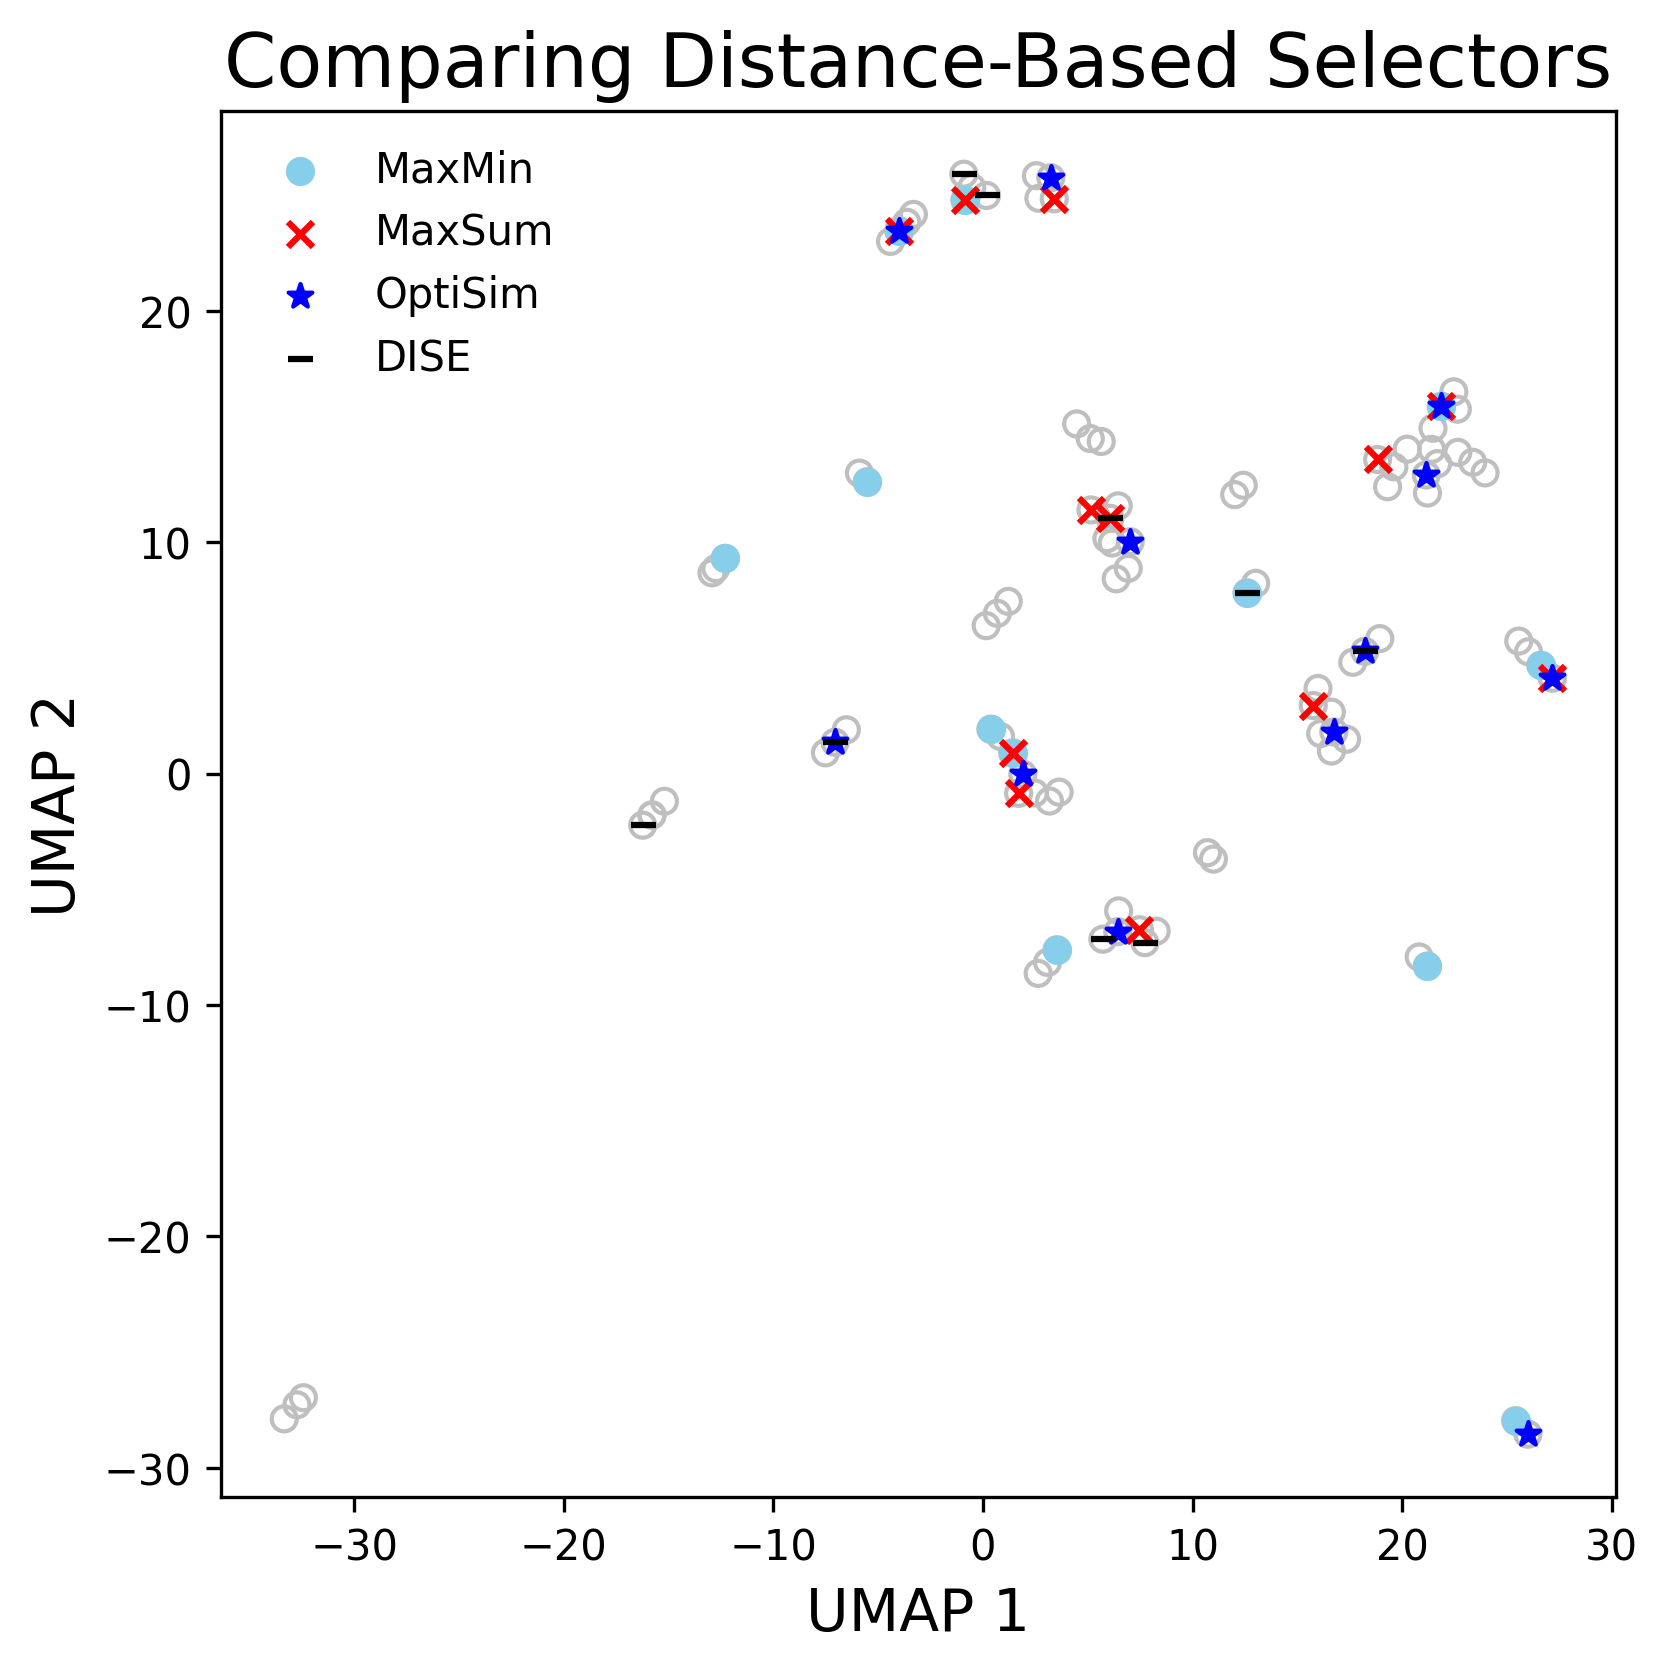

In [28]:
graph_data_2d(
    X_dist,
    projection_method="umap",
    indices=[index_maxmin, index_maxsum, index_optisim, index_dise],
    labels=["MaxMin", "MaxSum", "OptiSim", "DISE"],
    figsize=(6, 6),
    title="Comparing Distance-Based Selectors",
    xlabel="UMAP 1",
    ylabel="UMAP 2",
    fname="quick_start_compare_distance_methods",
)


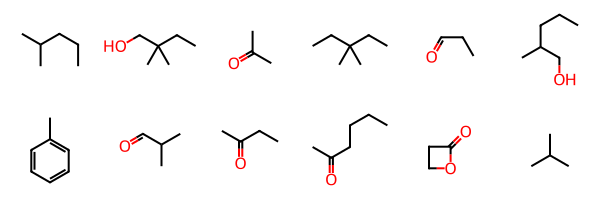

In [29]:
visualize_mols(input_sdf="demo_mols_2d.sdf", selected_ids=index_maxmin, show_mol_labels=False,
               sub_image_size=(100, 100), mols_per_row=6)


In [30]:
    # tsne = TSNE(n_components=2, random_state=42, perplexity=5, metric="precomputed", init="random")
    # data = tsne.fit_transform(X=X_dist, y=None)
